## Cell Nuclei Location Detection in Microscopy Images using Pixel wise Classification

These are the points I will be discussing in this notebook:
- Objective
- Dataset
- Analysis of the problem and the dataset
- Discussion of the approach
- Preprocessing of Data and proposals for any other preprocessing done
- Code
- Conclusion

#### Contact:
- __Name:__ Siddalingesha D S
- __Email:__ devarman@usc.edu
- __Location:__ Los Altos
- __Linkedin:__ https://www.linkedin.com/in/siddalingeshads/
- __Gtihub:__  https://github.com/SiddalingeshaDS


## Objective

The objective of the project was to identify and analyze the properties of the nuclei visible in histopathology samples taken from cancer patients. 

To achieve this I defined multiple tasks that has to be achieved:
1. Given an microscopy image, identify the nucleus locations.
2. Leverage the data of the nucleus locations per image and the information that the image is from cancerous or control sample to further investigate.

## Dataset

The dataset consisted of 100 labelled images, each consisting of a corresponding array of nuclei location with it. It also consisted of 321 unlabelled images of the samples.

## Analysis

### Identification of the Nucleus Locations

The problem can be treated as a pixel-wise classification problem. Based on the labels that is provided that corresponds to the pixel location of each nuclei, it can be used to create a mask of the images highlighting the locations of each nuclei in the corresponding input image.

One of the methods to use to solve such pixel wise segmentation/classification problem is  Mask RCNN architecture. However, Mask RCNN requires the label to be an annotated image highlighting the pixels of specific objects of interest in each ground truth image. Considering the given input labels are highlighting specific location of each nuclei and not the set of pixels, we have two solutions at hand:
- Manually relabel the images to highlight the pixels of interest
- Modify the architecture of Mask RCNN model to take label change into consideration.

These solutions are time consuming and would not be feasible as a first step to evaluate the entire process. Also, the label data is not that large to consider Mask RCNN deep learning model. Hence, as a first step, I want to try classical ML methods like SVM, Random Forest etc, or an ensemble of them to verify if anything can be learnt from the existing data.

Before we proceed with the approach, there are few assumptions I have made about the data.

#### Assumptions:
- The labels of each nuclei correspond to the location of the centroid pixel ( central pixel ) of the group of pixels that identify the nucleus. 
- Each nucleus is atleast few pixels away (3) from each other. 
- Observation: These microscopy images contain stained cell images with nuclei highlighted in darker stains.

The dataset was analysed and the ratio of nuclei locations to the total number of pixels is very high. It is a highly imbalanced dataset if we consider the number of nuclei to total number of pixels in the image. (9776515:23485) We cannot rely on the accuracy metric for providing any useful information.


Instead of treating this problem as a pixel-wise classification/segmentation problem, other alternate approaches can also be taken. For example, instead of using each pixel information, we can cluster them as super pixels. Super pixels are a concept where similar pixels are clustered in an unsuperivised method. They can be created by using algorithms like KMeans Clustering, Mean Shift Filtering, SLIC Superpixel algorithm available in OpenCV library. This can be included as a preprocessing step.

However, for the current iteration, I will consider pixel wise information only.


### Analyzing the nucleus location information

I stored the information about each nuclei location per image and a flag to identify if the image is from cancerous or control sample in a pandas dataframe. The output of the above model can be used to fill this dataframe for all the nucleus locations for the images in our dataset.

This information can be used to find the density of the nucleus in each image and use them as a feature to classify if the image is from cancerous or control sample. 


# Identification of the Nucleus Locations

## Approach

The approach is to do a pixel level classification of the image - if it contains an nuclei or not. I have used many models to train and different ways to tackle the class imbalance. 

#### Converting the input data to fit the task:
The input labels are converted to mask images. We first create a 360 x 360 numpy array, and mark the pixel locations with nucleus based on the json input of nuclei location corresponding to that image. 
At this step, I tried two approaches: 
- __Mark only one pixel per nuclei location as true labels__ - This allows us to be specific about the information that are treated as true value in our problem. We can add the adjacent information of the true pixel by using the output of colvolution filter as its features (more on this later).
- __Mark a block of 3x3 pixels around the nuclei location as true lables__ ( based on the assumption that the given ground truth labels correspond to centroid of atleast 3x3 nucleus) - This allows us to sythetically feed more true labels to the model as we observed a large imbalance in the true to false ratio in each image.

After creation of the mask image, the input images and the output masks are flattened to create the training dataset. Each entry in the training data corresponds to a pixel and its corresponding label of 0/1 to indicate if it is a nucleus pixel.

#### Feature selection:
The approach for feature selection is based on the observation that the color of the stain is different for nucleus and cell plasma. Based on this, I consider the following features:
1. RGB values - The RGB channel values in the image are considered as the features as they highlight what color each pixel is.
2. CIE LAB values - Desirable that same small distances in the color space correspond to the same (similar) perceptual differences, regardless of the absolute positions of the points in the space i.e, the LAB space is used because it maps the values of colors that are perceived similar within same distance. If there are two colors that appear similar, they have same distance between them in the LAB space. This allows to observe that the darker stain pixels(indicating the nucleus, cell borders, etc) are grouped together because of their similarity, and lighter stains pixels (indicating the plasma) are grouped together. 
3. Surrounding pixel features - A 3x3 filter is convolved for each pixel to get the surrounding information as a feature for each pixel. The observation is that, nucleus pixels are grouped together spatially, and addding this feature increases the chance of finding a centroid as compared to other darker stain pixels like cell borders, etc.


#### Selection of the algorithm:
The selection of the machine learning algorithm is quite intersting as the class imbalance makes it harder to reason out which might work better. I was more inclined towards trying out SVM models due to their inherent ability to classify outliers as well, but am aware that such higher imbalance ratio might make it difficult even with this. I wanted to try Random Forest as the next model, given that it allows us to reduce the variance error. I have tried variety of other models in my approach and heirarchial ensemble models as well. 


#### Dealing with class imbalance:
This might be the most important issue that had to be addressed in this case. By considering the problem to be a pixel level classification problem, I was faced with a large imbalanced data set. 

I tried multiple methods to overcome this:
1. Resampling the training set: 
    - I marked surrounding pixels of each nuclei location in the ground truth labels as nucleus pixels, there by increasing the True pixel size. This was to synthetically create more true labels based on the problem information that I possess (or the assumption I made).
    - Downsampling the false lables: The false labels were randomly selected from the training data set of pixels to match the true labels
2. Ensemble different resampled datasets: This was an interesting approach I tried where multiple resamples of the false labels were taken along with the true lables and various models were trained. These models were then used as an ensemble to provide the prediction.
3. Resample with different ratios: This extends the above idea to resample with an increasing ratio of false data for training each model. I introduced a beta parameter while creating training data set to increase the size of the false data set linearly.

These ideas are expressed in the following reference:
https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html





## Preprocessing

The preprocessing involved creating a mask image for each image which identifies the pixel that is the location of the nuclei.

## Code

The code is split into various modules:
1. Loading the data
2. Preprocessing and creating a training dataset
3. Feature selection
4. Running an ensemble for single classifier
5. Running an ensemble of multiple classifier
6. Inference for identification of nuclei location

### Setup

In [1]:
# Imports 
from glob import glob
import os
import numpy as np
import json
import scipy
import scipy.misc
from skimage import io, color
import cv2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import time
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
import math
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle as pkl

/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Setup
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### Loading the data

The data is loaded from the data folder. Any image that contains a label is considered as a training/validation/testing set. Everything else is considered a general testing dataset.

In [3]:
# Load the data
def load_data(data_folder, image_shape=(360, 360), mark_surrounding=False):
    '''
        Function to process the image and label files and return the list of trained images, train labels, test images and meta information for all images
    '''
    
    ## Get all the image paths from the data folder
    image_paths = glob(os.path.join(data_folder, 'images', '*.jpg'))
    # Get the label paths from the data folder
    label_paths = {
        os.path.basename(path).replace('.nuclei.json', '.jpg'): path
        for path in glob(os.path.join(data_folder, 'nuclei-locations', '*.nuclei.json'))}
    np.random.shuffle(image_paths)
    print('[INFO] Number of images and labels', len(image_paths), len(label_paths))
    train_image_list = []
    label_list = []
    test_image_list = []
    # Store the information of each image and nuclei location to use for analysis
    data = {'file_name': [],'cancerous': [], 'nucleus_x_pos': [], 'nucleus_y_pos': []}
    for image_file in image_paths:
        # Get the file name and if cancerous sample
        file_name = os.path.basename(image_file)
        cancerous = True if file_name.split('-')[3].startswith('01') else False
        # If there is a ground truth label
        if os.path.basename(image_file) in label_paths:
            with open(label_paths[os.path.basename(image_file)], 'rb') as f:
                text = f.read()
                obj = json.loads(text)
                label_image = np.zeros(image_shape)
                for nuclei in obj['nuclei']:
                    if mark_surrounding:
                        min_xrange = nuclei['x'] - 2
                        max_xrange = nuclei['x'] + 1
                        min_yrange = nuclei['y'] - 2
                        max_yrange = nuclei['y'] + 1
                    else:
                        min_xrange = nuclei['x'] - 1
                        max_xrange = nuclei['x']
                        min_yrange = nuclei['y'] - 1
                        max_yrange = nuclei['y']
                    for _x in range(max(min_xrange, 0), min(max_xrange, image_shape[0])):
                        for _y in range(max(min_yrange, 0), min(max_yrange, image_shape[1])):
                            label_image[_x, _y] = 1
                            data['file_name'].append(file_name)
                            data['cancerous'].append(cancerous)
                            data['nucleus_x_pos'].append(nuclei['x'] - 1)
                            data[ 'nucleus_y_pos'].append(nuclei['y'] - 1)
            
            image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
            train_image_list.append(image)
            label_list.append(label_image)
        else:
            data['file_name'].append(file_name)
            data['cancerous'].append(cancerous)
            data['nucleus_x_pos'].append(None)
            data[ 'nucleus_y_pos'].append(None)
            
            image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
            test_image_list.append(image)

    return train_image_list, label_list, test_image_list, data

def getMaskImage(src, label, img_shape=(360, 360)):
    segmentation = label.reshape(img_shape[0], img_shape[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 1]]))
    return mask

# Display the src image and the label information as a mask image
def displayImages(src, mask):
    fig=plt.figure()
    plt.imshow(src)
    fig=plt.figure()
    plt.imshow(mask)
    plt.show()


### Feature Selection

These functions define the feature creation methods.

In [4]:
'''
Reference: http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html
'''

def convolve2d(image, kernel):
    # This function which takes an image and a kernel 
    # and returns the convolution of them
    # Args:
    #   image: a numpy array of size [image_height, image_width].
    #   kernel: a numpy array of size [kernel_height, kernel_width].
    # Returns:
    #   a numpy array of size [image_height, image_width] (convolution output).
    
    kernel = np.flipud(np.fliplr(kernel))    # Flip the kernel
    output = np.zeros_like(image)            # convolution output
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))   
    image_padded[1:-1, 1:-1] = image
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y,x]=(kernel*image_padded[y:y+3,x:x+3]).sum()        
    return output

In [5]:
def get_features(image_list, label_list, features=['RGB', 'LAB', 'CONVOLVE'], scale=False):
    X = []
    y = []
    kernel = [[1, 1, 1,], [1, 1, 1], [1, 1, 1]]
    for i, img in enumerate(image_list):
        f = None
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        if 'LAB' in features:
            f = lab.reshape(lab.shape[0] * lab.shape[1], lab.shape[2])
            
        if 'RGB' in features:
            if f is not None:
                f = np.hstack((img.reshape(img.shape[0] * img.shape[1], img.shape[2]), f))
            else:
                f = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

        if 'CONVOLVE' in features:
            _l = convolve2d(lab[:,:,0], kernel).reshape(lab.shape[0] * lab.shape[1], 1)
            _a = convolve2d(lab[:,:,1], kernel).reshape(lab.shape[0] * lab.shape[1], 1)
            _b = convolve2d(lab[:,:,2], kernel).reshape(lab.shape[0] * lab.shape[1], 1)
            _lab = np.hstack((_l, _a, _b))

            _r = convolve2d(img[:, :, 0], kernel).reshape(img.shape[0] * img.shape[1], 1)
            _g = convolve2d(img[:, :, 1], kernel).reshape(img.shape[0] * img.shape[1], 1)
            _b = convolve2d(img[:, :, 2], kernel).reshape(img.shape[0] * img.shape[1], 1)
            _rgb = np.hstack((_r, _g, _b))

            _f = np.hstack((_lab, _rgb))
            if f is not None:
                f = np.hstack((_f, f))
            else:
                f = _f
        label = label_list[i].ravel()
        X.append(f)
        y.append(label)
    X = np.concatenate(tuple(X))
    # Scale the features
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    y = np.array(y).ravel()
    print('[INFO] Features shape', X.shape, y.shape)
    return X, y


### Creation of the training dataset

This function is used to create batches of training datsets that are used by the ensemble of the models. This function helps to manage the imbalance in the training dataset.

In [6]:
def create_training_dataset(X, y, beta=0.1):
    print ('[INFO] Creating training dataset on %d pixels(s).' %len(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print ('[INFO] Feature vector size:', X.shape, X_train.shape, X_test.shape)
    idx_1 = np.where(y_train >0)[0]
    idx_0 = np.where(y_train < 1)[0]
    print('[INFO] Distribution of False and True labels', len(idx_0), len(idx_1))
    np.random.shuffle(idx_0)
    k = 0
    for i in range(0, len(idx_0), len(idx_1)):
        val = int(k * len(idx_1))
        X_batch = np.concatenate((X_train[i:i+len(idx_1) + val], X_train[idx_1]))
        y_batch = np.concatenate((y_train[i:i+len(idx_1) + val], y_train[idx_1]))
        unique_elements, counts_elements = np.unique(y_batch, return_counts=True)
        print('[INFO] Distribution of False and True labels in the batch: ', dict(zip(unique_elements, counts_elements)))
        k += beta
        i += val
        print('[INFO] Training data and label shape', X_batch.shape,y_batch.shape)
        yield X_batch, X_test, y_batch, y_test


### Training the model

This is a helper function to train a model for various classifiers. This is used while creating the ensemble model and while evaluating variety of the algorithms.

In [7]:
def train_model(X, y, classifier):

    if classifier == "SVM":
        from sklearn.svm import LinearSVC
        print ('[INFO] Training Support Vector Machine model.')
        model = LinearSVC(random_state=42)
        model.fit(X, y)
    elif classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        print ('[INFO] Training Random Forest model.')
        model = RandomForestClassifier(n_estimators=12, max_depth=10, random_state=42)
        model.fit(X, y)
    elif classifier == "GBC":
        from sklearn.ensemble import GradientBoostingClassifier
        print ('[INFO] Training Gradient Boosting Classifier model.')
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
        model.fit(X, y)
        
    elif classifier == 'BG':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        print ('[INFO] Training Bagging Classifier model.')
        model = BaggingClassifier(
            DecisionTreeClassifier(random_state=42), n_estimators=500,
            max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
        model.fit(X, y)
        
    elif classifier == 'ADA':
        from sklearn.ensemble import AdaBoostClassifier
        from sklearn.tree import DecisionTreeClassifier
        print ('[INFO] Training AdaBoost Classifier model.')
        model = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), n_estimators=200,
            algorithm="SAMME.R", learning_rate=0.5, random_state=42)
        model.fit(X, y)
    elif classifier == 'XGB':
        from xgboost import XGBClassifier
        print ('[INFO] Training XGBoost Classifier model.')
        model = XGBClassifier()
        model.fit(X, y)
    accuracy = model.score(X, y)
    print ('[INFO] Model training complete.')
    print ('[INFO] Training Accuracy: %.2f' %accuracy)
    return model, accuracy

def test_model(X, y, model):

    pred = model.predict(X)
    precision = metrics.precision_score(y, pred, average='weighted', labels=np.unique(pred))
    recall = metrics.recall_score(y, pred, average='weighted', labels=np.unique(pred))
    f1 = metrics.f1_score(y, pred, average='weighted', labels=np.unique(pred))
    accuracy = metrics.accuracy_score(y, pred)

    print ('--------------------------------')
    print ('[RESULTS] Accuracy: %.2f' %accuracy)
    print ('[RESULTS] Precision: %.2f' %precision)
    print ('[RESULTS] Recall: %.2f' %recall)
    print ('[RESULTS] F1: %.2f' %f1)
    print ('--------------------------------')
    return accuracy, precision, recall, f1


### Training an ensemble classifier for single algorithm

This is the main function that trains an ensemble of models for a certain classifer with/without resample of imbalanced dataset with different ratio.

In [8]:
def run_classifier(X, y, classifier, output_model, features, n_estimators=10, beta=0.1):

    start = time.time()
    estimator_results_train_accuracy = []
    estimator_results_test_accuracy = []
    estimator_results_test_precision = []
    estimator_results_test_recall = []
    estimator_results_test_f1 = []
    estimators = []
    total_test_X = None
    total_test_y = None
    total_train_X = None
    total_train_y = None
    i = 0
    for X_train, X_test, y_train, y_test in create_training_dataset(X, y, beta):
        print ('[INFO] Training Ensemble:', str(i))
        model, train_accuracy = train_model(X_train, y_train, classifier)
        test_accuracy, precision, recall, f1 = test_model(X_test, y_test, model)
        estimators.append((classifier + '_model_' + str(i), model))
        estimator_results_train_accuracy.append(train_accuracy)
        estimator_results_test_accuracy.append(test_accuracy)
        estimator_results_test_precision.append(precision)
        estimator_results_test_recall.append(recall)
        estimator_results_test_f1.append(f1)
        if total_test_X is None:
            total_train_X = X_train
            total_train_y = y_train
            total_test_X = X_test
            total_test_y = y_test
        else:
            total_train_X = np.concatenate((X_train, total_train_X))
            total_train_y = np.concatenate((y_train, total_train_y))
            
        if i == n_estimators:
            break
        i += 1
    print('----------------------------------')
    print('[INFO] ENSEMBLE Training completed:')
    print('[INFO] Total Training data', total_train_X.shape, total_train_y.shape)
    print('[INFO] Total Test data', total_test_X.shape, total_test_y.shape)

    final_ensemble = VotingClassifier(estimators)
    final_ensemble.fit(total_train_X, total_train_y)
    test_accuracy, precision, recall, f1 = test_model(total_test_X, total_test_y, final_ensemble)
    
    print('[INFO] Saving the model', output_model)
    pkl.dump(final_ensemble, open(output_model, "wb"))
    print ('Processing time:',time.time()-start)
    estimator_results = {'train_accuracy': estimator_results_train_accuracy, 'test_accuracy': estimator_results_test_accuracy, 'precision': estimator_results_test_precision, 'recall': estimator_results_test_recall, 'f1': estimator_results_test_f1 }
    return estimator_results,  {'train_accuracy': final_ensemble.score, 'test_accuracy': test_accuracy, 'precision': precision, 'recall': recall, 'f1': f1 }

### Training an ensemble model in hierarchy of different models

This is the main function that trains a heirarchy of ensemble of models for a different classifers with/without resample of imbalanced dataset with different ratio.

In [9]:
def run_ensemble_for_all(X, y, output_model, features, n_estimators=10, beta=0.1):

    start = time.time()
    estimators = {}
    estimator_results = {}
    total_test_X = None
    total_test_y = None
    total_train_X = None
    total_train_y = None
    i = 0
    classifiers = ['SVM', 'RF', 'GBC', 'BG', 'ADA', 'XGB']
    for X_train, X_test, y_train, y_test in create_training_dataset(image_list, label_list, features):
        print ('[INFO] Training Ensemble:', str(i))
        for classifier in classifiers:
            model, train_accuracy = train_model(X_train, y_train, classifier)
            test_accuracy, precision, recall, f1 = test_model(X_test, y_test, model)
            if classifier not in estimators:
                estimators[classifier] = []
                estimator_results[classifier] = []
            estimators[classifier].append((classifier + '_model_' + str(i), model))
            estimator_results[classifier].append({'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy, 'precision': precision, 'recall': recall, 'f1': f1 })
        if total_test_X is None:
            total_train_X = X_train
            total_train_y = y_train
            total_test_X = X_test
            total_test_y = y_test
        else:
            total_train_X = np.concatenate((X_train, total_train_X))
            total_train_y = np.concatenate((y_train, total_train_y))
            
        if i == n_estimators:
            break
        i += 1
    print('----------------------------------')
    print('[INFO] ENSEMBLE Training completed:')
    print('[INFO] Total Training data', total_train_X.shape, total_train_y.shape)
    print('[INFO] Total Test data', total_test_X.shape, total_test_y.shape)
    main_estimators = []
    main_estimator_results = []
    for k in list(estimators.keys()):
        print ('[INFO]', k, 'Training Final Ensemble')
        ensemble = VotingClassifier(estimators[k])
        ensemble.fit(total_train_X, total_train_y)
        test_accuracy, precision, recall, f1 = test_model(total_test_X, total_test_y, ensemble)
        main_estimators.append((k + '_ensemble_model', ensemble))
        main_estimator_results.append({'train_accuracy': ensemble.score, 'test_accuracy': test_accuracy, 'precision': precision, 'recall': recall, 'f1': f1 })

    final_ensemble = VotingClassifier(main_estimators)
    final_ensemble.fit(total_train_X, total_train_y)
    test_accuracy, precision, recall, f1 = test_model(total_test_X, total_test_y, final_ensemble)
    print('[INFO] Saving the model', output_model)
    pkl.dump(final_ensemble, open(output_model, "wb"))
    print ('Processing time:',time.time()-start)
    return estimator_results, main_estimator_results, {'train_accuracy': final_ensemble.score, 'test_accuracy': test_accuracy, 'precision': precision, 'recall': recall, 'f1': f1 }

### Plotting functions

In [10]:
def plot_estimator_results(data):
    plt.figure(figsize=(12,7))
    plt.xlabel('Number of estimators')
    plt.ylabel('Metrics')
    l = range(len(data['train_accuracy']))
    line, = plt.plot(l,data['train_accuracy'], '-', label='Train Accuracy')
    line, = plt.plot(l,data['train_accuracy'], '-', label='Test Accuracy')
    line, = plt.plot(l,data['precision'], '-', label='Test Precision')
    line, = plt.plot(l,data['recall'], '-', label='Test Recall')
    line, = plt.plot(l,data['f1'], '-', label='Test F1')
    plt.legend()
    plt.show()

### Testing the models

In [61]:
def infer_create_features(img, features=['RGB', 'LAB', 'CONVOLVE'], scale=False, image_shape=(360,360)):
    img = scipy.misc.imresize(img, image_shape)
    f = None
    kernel = [[1, 1, 1,], [1, 1, 1], [1, 1, 1]]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    if 'LAB' in features:
        f = lab.reshape(lab.shape[0] * lab.shape[1], lab.shape[2])

    if 'RGB' in features:
        if f is not None:
            f = np.hstack((img.reshape(img.shape[0] * img.shape[1], img.shape[2]), f))
        else:
            f = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
            
            
    if 'CONVOLVE' in features:
        _l = convolve2d(lab[:,:,0], kernel).reshape(lab.shape[0] * lab.shape[1], 1)
        _a = convolve2d(lab[:,:,1], kernel).reshape(lab.shape[0] * lab.shape[1], 1)
        _b = convolve2d(lab[:,:,2], kernel).reshape(lab.shape[0] * lab.shape[1], 1)
        _lab = np.hstack((_l, _a, _b))

        _r = convolve2d(img[:, :, 0], kernel).reshape(img.shape[0] * img.shape[1], 1)
        _g = convolve2d(img[:, :, 1], kernel).reshape(img.shape[0] * img.shape[1], 1)
        _b = convolve2d(img[:, :, 2], kernel).reshape(img.shape[0] * img.shape[1], 1)
        _rgb = np.hstack((_r, _g, _b))
        
        _f = np.hstack((_lab, _rgb))
        if scale: 
            scaler = MinMaxScaler()
            scaler.fit(_f)
            _f = scaler.transform(_f)
            
        if f is not None:
            f = np.hstack((_f, f))
        else:
            f = _f

        print('[INFO] Test Features', f.shape)
    return f

def compute_prediction(img, y, model, features):
    features = infer_create_features(img, features)
    predictions = model.predict(features)
    unique_elements, counts_elements = np.unique(predictions, return_counts=True)
    precision = metrics.precision_score(y, predictions, average='weighted', labels=np.unique(predictions))
    recall = metrics.recall_score(y, predictions, average='weighted', labels=np.unique(predictions))
    f1 = metrics.f1_score(y, predictions, average='weighted', labels=np.unique(predictions))
    accuracy = metrics.accuracy_score(y, predictions)
    print('[INFO] Test Results')
    print ('--------------------------------')
    print ('[RESULTS] Accuracy: %.2f' %accuracy)
    print ('[RESULTS] Precision: %.2f' %precision)
    print ('[RESULTS] Recall: %.2f' %recall)
    print ('[RESULTS] F1: %.2f' %f1)
    print ('--------------------------------')
    
    
    
    print('[INFO] Distribution of False and True labels', dict(zip(unique_elements, counts_elements)))
    print('[INFO] Prediction shape', predictions.shape)
    inference_img = getMaskImage(img, predictions)
    return inference_img

def infer_train_images(image_dir,model_path, output_dir, features):
    filelist = glob(image_dir+'/*.jpg')
    
#     labellist = glob(image_dir.replace('images', 'nuclei-locations') + '/*.json')
    labellist = {
        os.path.basename(path).replace('.nuclei.json', '.jpg'): path
        for path in glob(os.path.join('project-data', 'nuclei-locations', '*.nuclei.json'))}
    print ('[INFO] Running inference on 10 images')
    model = pkl.load(open( model_path, "rb" ) )
    inference_img_list = []
    i = 1
    for file in filelist:
        if os.path.basename(file.split('/')[-1]) in labellist:
            print ('[INFO] Processing image:', str(i))
            i += 1
            label_path = os.path.join('project-data/nuclei-locations',os.path.basename(file.split('/')[-1]).replace('.jpg', '.nuclei.json'))
            print(label_path)
            with open(label_path, 'rb') as f:
                text = f.read()
                obj = json.loads(text)
                label_image = np.zeros((360, 360))
                print('[INFO] Number of Nuclei in Ground Truth', len(obj['nuclei']))
                for nuclei in obj['nuclei']:
                    label_image[nuclei['x'] - 1, nuclei['y'] - 1] = 1
            print()
            _y = label_image.ravel()
            inference_img = compute_prediction(cv2.imread(file, 1), _y, model, features)
            inference_img_list.append((file, inference_img))
            print()
            print()
            if i == 10:
                break
    return inference_img_list
    
def infer_test_images(image_dir,model_path, output_dir, features):
    filelist = glob(image_dir+'/*.jpg')
    print ('[INFO] Running inference on %s test images' %len(filelist))
    model = pkl.load(open( model_path, "rb" ) )
    inference_img_list = []
    i = 1
    for file in filelist:
        print ('[INFO] Processing image:', str(i))
        i += 1
        features = infer_create_features(cv2.imread(file, 1), features)
        predictions = model.predict(features)
        unique_elements, counts_elements = np.unique(predictions, return_counts=True)
        print('[INFO] Distribution of False and True labels', dict(zip(unique_elements, counts_elements)))
        inference_img_list.append(inference_img)
        cv2.imwrite(output_dir+'/'+file.split('/')[-1], inference_img)


    return inference_img_list

    

### Execution

In [12]:
train_image_list, label_list, test_image_list, meta_data = load_data('project-data', (360, 360))

[INFO] Number of images and labels 421 100


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [13]:
df = pd.DataFrame.from_dict(meta_data)
df.head()

,file_name,cancerous,nucleus_x_pos,nucleus_y_pos
0,TCGA-A3-3359-11A-01-TS1.21-99.82Y.jpg,False,NaN,NaN
1,TCGA-A3-3374-11A-01-TS1.33-57.51Y.jpg,False,NaN,NaN
2,TCGA-A3-3358-11A-01-TS1.102-72.57Y.jpg,False,335.0,237.0
3,TCGA-A3-3358-11A-01-TS1.102-72.57Y.jpg,False,298.0,25.0
4,TCGA-A3-3358-11A-01-TS1.102-72.57Y.jpg,False,282.0,34.0


In [14]:
X, y = get_features(train_image_list, label_list, ['LAB', 'RGB', 'CONVOLVE'])

[INFO] Features shape (12960000, 12) (12960000,)


In [46]:
# Train the Random Forest classifier ensemble with beta 0.1
estimator_results, final_estimator_results = run_classifier(X, y, 'RF', 'models/Ensemble_model_RF.pkl', ['LAB', 'RGB', 'CONVOLVE'], n_estimators=5, beta=0.1)

[INFO] Creating training dataset on 12960000 pixels(s).
[INFO] Feature vector size: (12960000, 12) (10368000, 12) (2592000, 12)
[INFO] Distribution of False and True labels 10344640 23360
[INFO] Distribution of False and True labels in the batch:  {0.0: 23306, 1.0: 23414}
[INFO] Training data and label shape (46720, 12) (46720,)
[INFO] Training Ensemble: 0
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 0.62
--------------------------------
[RESULTS] Accuracy: 0.47
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.47
[RESULTS] F1: 0.64
--------------------------------
[INFO] Distribution of False and True labels in the batch:  {0.0: 25631, 1.0: 23425}
[INFO] Training data and label shape (49056, 12) (49056,)
[INFO] Training Ensemble: 1
[INFO] Training Random Forest model.
[INFO] Model training complete.
[INFO] Training Accuracy: 0.62
--------------------------------
[RESULTS] Accuracy: 0.74
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.74
[RES

/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--------------------------------
[RESULTS] Accuracy: 0.95
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.95
[RESULTS] F1: 0.97
--------------------------------
[INFO] Saving the model models/Ensemble_model_RF.pkl
Processing time: 94.82309484481812


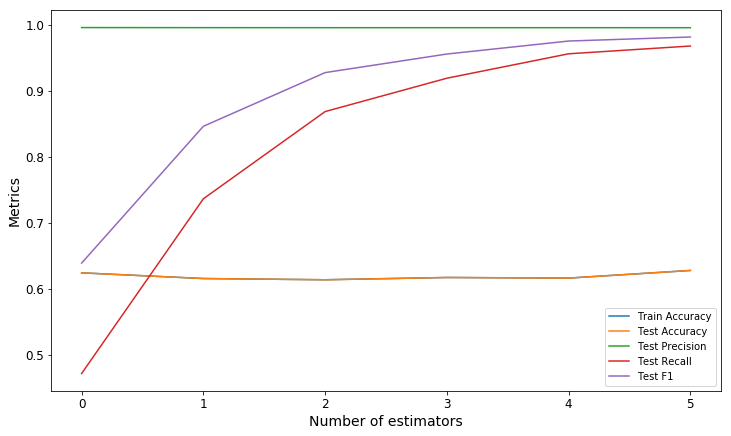

In [47]:
plot_estimator_results(estimator_results)

In [62]:
# Run the inference on the sample 10 train images
pred_list = infer_train_images('project-data/images', 'models/Ensemble_model_RF.pkl', 'output', ['LAB', 'RGB', 'CONVOLVE'])

[INFO] Running inference on 10 images
[INFO] Processing image: 1
project-data/nuclei-locations/TCGA-A3-3347-11A-01-TS1.9-18.76Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 343



/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.87
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.87
[RESULTS] F1: 0.93
--------------------------------
[INFO] Distribution of False and True labels {0.0: 113431, 1.0: 16169}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 2
project-data/nuclei-locations/TCGA-A3-3358-01Z-00-DX1.24-147.57Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 194

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.92
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.92
[RESULTS] F1: 0.95
--------------------------------
[INFO] Distribution of False and True labels {0.0: 118850, 1.0: 10750}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 3
project-data/nuclei-locations/TCGA-A3-3343-01Z-00-DX1.105-24.79Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 188

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.91
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.91
[RESULTS] F1: 0.95
--------------------------------
[INFO] Distribution of False and True labels {0.0: 118426, 1.0: 11174}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 4
project-data/nuclei-locations/TCGA-A3-3349-11A-01-TS1.75-198.34Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 383

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.90
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.90
[RESULTS] F1: 0.95
--------------------------------
[INFO] Distribution of False and True labels {0.0: 117093, 1.0: 12507}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 5
project-data/nuclei-locations/TCGA-A3-3358-01Z-00-DX1.42-27.57Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 583

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.87
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.87
[RESULTS] F1: 0.93
--------------------------------
[INFO] Distribution of False and True labels {0.0: 113708, 1.0: 15892}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 6
project-data/nuclei-locations/TCGA-A3-3343-11A-01-TS1.33-63.79Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 463

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.88
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.88
[RESULTS] F1: 0.93
--------------------------------
[INFO] Distribution of False and True labels {0.0: 113768, 1.0: 15832}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 7
project-data/nuclei-locations/TCGA-A3-3351-01A-02-BS2.90-27.42Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 276

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.87
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.87
[RESULTS] F1: 0.93
--------------------------------
[INFO] Distribution of False and True labels {0.0: 113068, 1.0: 16532}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 8
project-data/nuclei-locations/TCGA-A3-3347-11A-01-TS1.24-36.76Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 446

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.84
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.84
[RESULTS] F1: 0.91
--------------------------------
[INFO] Distribution of False and True labels {0.0: 109626, 1.0: 19974}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 9
project-data/nuclei-locations/TCGA-A3-3358-11A-01-TS1.96-126.57Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 262

[INFO] Test Features (129600, 12)
[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.91
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.91
[RESULTS] F1: 0.95
--------------------------------
[INFO] Distribution of False and True labels {0.0: 117580, 1.0: 12020}
[INFO] Prediction shape (129600,)




/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


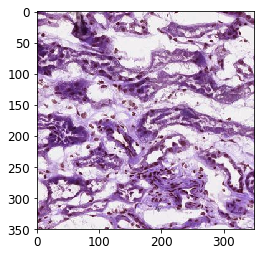

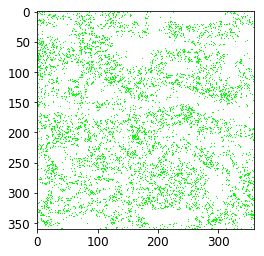

In [63]:
displayImages(cv2.imread(pred_list[0][0], 1),pred_list[0][1] )

In [64]:
# Train the SVM classifier ensemble with beta 0.1
estimator_results, final_estimator_results = run_classifier(X, y, 'SVM', 'models/Ensemble_model_SVM.pkl', ['LAB', 'RGB', 'CONVOLVE'], n_estimators=5, beta=0.1)

[INFO] Creating training dataset on 12960000 pixels(s).
[INFO] Feature vector size: (12960000, 12) (10368000, 12) (2592000, 12)
[INFO] Distribution of False and True labels 10344640 23360
[INFO] Distribution of False and True labels in the batch:  {0.0: 23306, 1.0: 23414}
[INFO] Training data and label shape (46720, 12) (46720,)
[INFO] Training Ensemble: 0
[INFO] Training Support Vector Machine model.
[INFO] Model training complete.
[INFO] Training Accuracy: 0.50
--------------------------------
[RESULTS] Accuracy: 0.86
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.86
[RESULTS] F1: 0.92
--------------------------------
[INFO] Distribution of False and True labels in the batch:  {0.0: 25631, 1.0: 23425}
[INFO] Training data and label shape (49056, 12) (49056,)
[INFO] Training Ensemble: 1
[INFO] Training Support Vector Machine model.
[INFO] Model training complete.
[INFO] Training Accuracy: 0.48
--------------------------------
[RESULTS] Accuracy: 0.07
[RESULTS] Precision: 1.00
[RESULTS]

/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--------------------------------
[RESULTS] Accuracy: 0.95
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.95
[RESULTS] F1: 0.97
--------------------------------
[INFO] Saving the model Ensemble_model_SVM.pkl
Processing time: 467.36135601997375


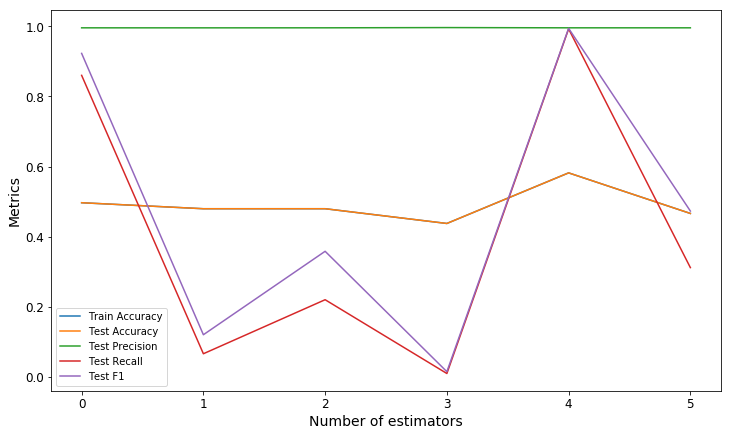

In [65]:
plot_estimator_results(estimator_results)

In [67]:
pred_list = infer_train_images('project-data/images', 'models/Ensemble_model_SVM.pkl', 'output', ['LAB', 'RGB', 'CONVOLVE'])

[INFO] Running inference on 10 images
[INFO] Processing image: 1
project-data/nuclei-locations/TCGA-A3-3347-11A-01-TS1.9-18.76Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 343



/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.94
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.94
[RESULTS] F1: 0.96
--------------------------------
[INFO] Distribution of False and True labels {0.0: 121665, 1.0: 7935}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 2
project-data/nuclei-locations/TCGA-A3-3358-01Z-00-DX1.24-147.57Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 194

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.97
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.97
[RESULTS] F1: 0.98
--------------------------------
[INFO] Distribution of False and True labels {0.0: 125335, 1.0: 4265}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 3
project-data/nuclei-locations/TCGA-A3-3343-01Z-00-DX1.105-24.79Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 188

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.97
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.97
[RESULTS] F1: 0.98
--------------------------------
[INFO] Distribution of False and True labels {0.0: 126039, 1.0: 3561}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 4
project-data/nuclei-locations/TCGA-A3-3349-11A-01-TS1.75-198.34Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 383

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.96
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.96
[RESULTS] F1: 0.98
--------------------------------
[INFO] Distribution of False and True labels {0.0: 125270, 1.0: 4330}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 5
project-data/nuclei-locations/TCGA-A3-3358-01Z-00-DX1.42-27.57Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 583

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.95
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.95
[RESULTS] F1: 0.97
--------------------------------
[INFO] Distribution of False and True labels {0.0: 123756, 1.0: 5844}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 6
project-data/nuclei-locations/TCGA-A3-3343-11A-01-TS1.33-63.79Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 463

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.96
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.96
[RESULTS] F1: 0.98
--------------------------------
[INFO] Distribution of False and True labels {0.0: 125011, 1.0: 4589}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 7
project-data/nuclei-locations/TCGA-A3-3351-01A-02-BS2.90-27.42Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 276

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.82
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.82
[RESULTS] F1: 0.90
--------------------------------
[INFO] Distribution of False and True labels {0.0: 106776, 1.0: 22824}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 8
project-data/nuclei-locations/TCGA-A3-3347-11A-01-TS1.24-36.76Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 446

[INFO] Test Features (129600, 12)


/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.95
[RESULTS] Precision: 0.99
[RESULTS] Recall: 0.95
[RESULTS] F1: 0.97
--------------------------------
[INFO] Distribution of False and True labels {0.0: 123556, 1.0: 6044}
[INFO] Prediction shape (129600,)


[INFO] Processing image: 9
project-data/nuclei-locations/TCGA-A3-3358-11A-01-TS1.96-126.57Y.nuclei.json
[INFO] Number of Nuclei in Ground Truth 262

[INFO] Test Features (129600, 12)
[INFO] Test Results
--------------------------------
[RESULTS] Accuracy: 0.98
[RESULTS] Precision: 1.00
[RESULTS] Recall: 0.98
[RESULTS] F1: 0.99
--------------------------------
[INFO] Distribution of False and True labels {0.0: 126706, 1.0: 2894}
[INFO] Prediction shape (129600,)




/Users/sshivakumar2/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


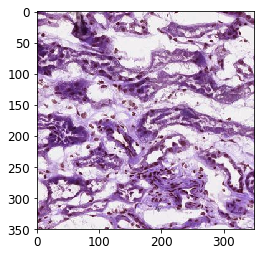

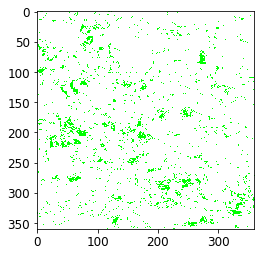

In [68]:
displayImages(cv2.imread(pred_list[0][0], 1),pred_list[0][1] )

## Observations and Challenges

Observations:
- As the ratio of false to true pixels increases, the metrics increases a lot. This might be because the ratio is so high that it does not matter the difference in predicting all false would do.
- While using the model to identify the nuclei locations, there are lot of false positives that need to be refined.
- However, the recall is also high, indicating that the actual nuclei locations are also getting picked in the bunch of false positives.

Challenges:
- Formulating the problem and deciding on approach to use
- Dealing with imbalanced data
- Designing the pipeline to find the nucleus location and use that to analyze and answer more questions about the nuclei density etc,.


## Next Steps.....

### Identification of Nuclei locations
#### Data Visuaization and Analysis
Given more time, I would have spent trying to analyze the input data. I would have spent time on plotting the true vs false pixels for the features I have identified. 


#### Feature Engineering and Tuning
There were a multiple of methods I wanted to try. Specifically as a preprocessing, in getting better labels to improve the pixel wise classification:
1. Use more features like SIFT key features, creating a feature pyramid with convolutions, etc.
2. Apply Mean Shift Clustering to smooth and segment the image as a preprocessing step for pixel wise classfication.
(Ref: http://vision.stanford.edu/teaching/cs131_fall1314_nope/lectures/lecture13_kmeans_cs131.pdf)
3. Use proposal generation algorithms like Selective Search to merge similar pixels in spatial adjacency to identify the pixels of nucleus in training dataset.(Ref: http://vision.stanford.edu/teaching/cs231b_spring1415/slides/ssearch_schuyler.pdf)

#### Model Selection

I wanted to try image segmentation approaches using Deep Learning architectures. I recently worked on a project to segment the road vs not-a-road in KITTI image dataset. I was trying out a FCN32 model to do the segmentation and I wanted to check if this method would provide any better results in this problem.

Also, I could use a weighted ensemble with soft voting instead of hard voting based on the performance on the training/validation set. 
#### Hyperparameter tuning

I would have tried to change the values of the beta and number of estimators in the ensemble model creation. I have tried few combinations. But would have wanted to learn more of the effect of different setup.

### Analysis of nuclei locations per image

I wanted to use the output of the model and perform some kind of descriptive analysis to answer the questions presented in the project requirements.

## Conclusion

This was an interesting project, because it allowed me to explore the techniques I learnt as part of Machine Learning, Deep Learning and Computer Vision courses to solve the problem. It gave me an opportunity to spend some time understanding how nuclei/cell identification is done in microscopy images. 

Please feel free to reach out to me if you have any questions/issues running this notebook.

### References
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961826/
- http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6790/pdf/imm6790.pdf
- https://ieeexplore.ieee.org/document/7544809
